In [2]:
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from os import listdir
from os.path import isfile, join, isdir
from shapely.geometry import Point, Polygon
import descartes
import math
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d

First of all, we are looking at the positions of air pollutants stations throught Europe


In [3]:
import chardet
RELATIVE_DATA_PATH = './data'

# Load metadata
metadata = pd.read_csv(join(RELATIVE_DATA_PATH, 'metadata.csv'))
metadata.columns


Index(['Countrycode', 'Namespace', 'AirQualityNetwork', 'AirQualityStation',
       'AirQualityStationNatCode', 'AirQualityStationEoICode',
       'AirQualityStationArea', 'SamplingPoint', 'SamplingProcess', 'Sample',
       'BuildingDistance', 'EquivalenceDemonstrated', 'InletHeight',
       'KerbDistance', 'MeasurementEquipment', 'MeasurementType',
       'MeasurementMethod', 'AirPollutantCode', 'AirPollutant',
       'AirQualityStationType', 'Projection', 'Longitude', 'Latitude',
       'Altitude'],
      dtype='object')

In [4]:
# Load data
def loadDataPollutant(countries, pollutant, cols):
    print(f"Loading pollutant: ${pollutant}")
    countries_data = {}
    for country in countries: #countries[:2]:
        frames = []
        print(f"Parsing {country}\n")
        pollutantsPath = join(RELATIVE_DATA_PATH, country)
        pollutantsPath = pollutantsPath + pollutant
        pollutants = listdir(pollutantsPath)
        
        if not pollutants:
            continue
            
        for dataCSV in pollutants:
            dataCSVPath = join(pollutantsPath, dataCSV)        
            with open(dataCSVPath, 'rb') as f:
                info = chardet.detect(f.read())
                currentCSV = pd.read_csv(dataCSVPath, sep=',', usecols=cols, encoding=info.get('encoding'))

                data = pd.DataFrame(currentCSV)

                # Convert data columns
                try:
                    data.DatetimeBegin = pd.to_datetime(data.DatetimeBegin)
                    data.DatetimeEnd = pd.to_datetime(data.DatetimeEnd)
                    # Set index
                    data.set_index(['DatetimeBegin'], inplace = True)
                    # Sort by index (by DatetimeBegin)
                    data.sort_index(inplace=True)
                    frames.append(data)
                except:
                    print("No datetime data")
        countries_data[country] = pd.concat(frames)
    print('End')
    return countries_data


In [23]:
# Load O3 data for CH
countries = ['CH']
pollutants = ['/CO/', '/NO2/', '/SO2', '/O3', '/PM10']
cols = ['Countrycode', 'AirQualityStation', 'Concentration', 'DatetimeBegin', 'DatetimeEnd', 'AirPollutant']

countries_data = pd.DataFrame()
for pollutant in pollutants:
    currentPollutantData = pd.concat(loadDataPollutant(countries, pollutant, cols).values(), sort=True)
    countries_data = countries_data.append(currentPollutantData, ignore_index=False)

countries_data.sort_index(inplace = True)
countries_data.head()


Loading pollutant: $/CO/
Parsing CH

End
Loading pollutant: $/NO2/
Parsing CH

End
Loading pollutant: $/SO2
Parsing CH

End
Loading pollutant: $/O3
Parsing CH

End
Loading pollutant: $/PM10
Parsing CH

End


,AirPollutant,AirQualityStation,Concentration,Countrycode,DatetimeEnd
DatetimeBegin,,,,,
2013-01-01 00:00:00+01:00,CO,STA-CH0002R,0.329,CH,2013-01-01 01:00:00+01:00
2013-01-01 00:00:00+01:00,NO2,STA-CH0002R,13.000,CH,2013-01-01 01:00:00+01:00
2013-01-01 00:00:00+01:00,NO2,STA-CH0002R,13.000,CH,2013-01-01 01:00:00+01:00
2013-01-01 00:00:00+01:00,O3,STA-CH0002R,22.500,CH,2013-01-01 01:00:00+01:00
2013-01-01 00:00:00+01:00,O3,STA-CH0002R,22.500,CH,2013-01-01 01:00:00+01:00


In [9]:
# Save data to pickle
countries_data.to_pickle("./countried_timestory_data.pkl")



For each country we are going to choose a AirQualityStation and compare the values of their pollutants


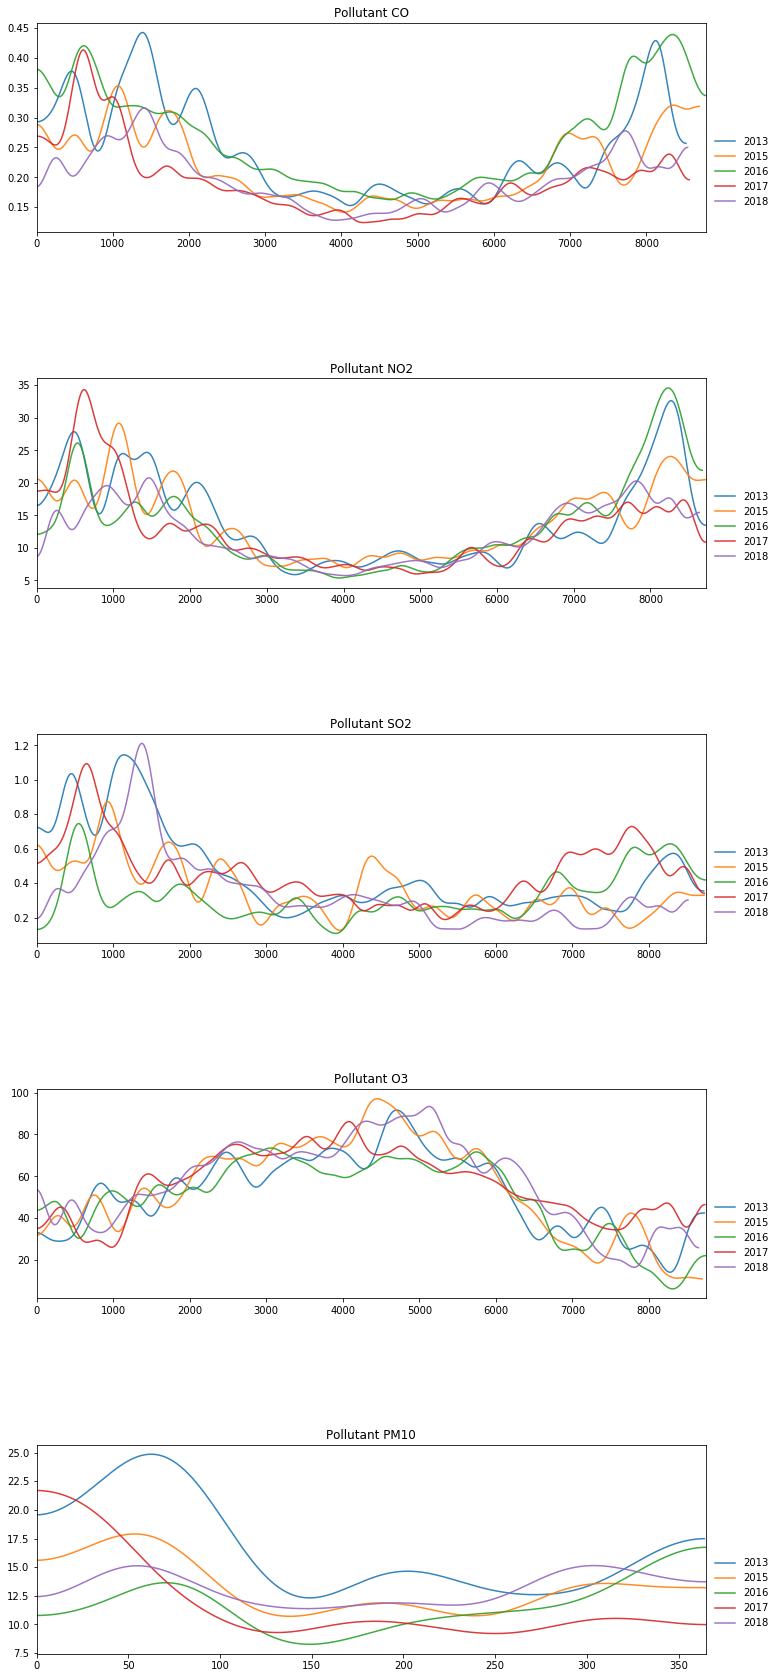

In [39]:
ncols = 1
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(12, 6 * nrows))
plt.subplots_adjust(hspace = 0.7)

indx = 0
sigmas = [130, 130, 130, 130, 30]
for pollutant in pollutants:
    pollutant = pollutant.split('/')[1]
    dataByPollutant = countries_data[ countries_data.AirPollutant == pollutant ]
    dataByPollutant = dataByPollutant.loc[~dataByPollutant.index.duplicated(keep='first')]
    for year in range(2013, 2019):
        if year == 2014:
            continue
            
        thisYear = str(year) + '-01-01 00:00:00+0100'
        nextYear = str(year + 1) + '-01-01 00:00:00+0100'

        dataInYear = dataByPollutant.loc[ thisYear : nextYear ]
        dataInYear = dataInYear.reset_index(drop=True)
        if dataInYear.shape[0] == 0:
            continue

        dataInYear['ConcentrationSmooth'] = gaussian_filter1d(dataInYear.Concentration, sigma=sigmas[indx])
        dataInYear.ConcentrationSmooth.plot(ax = axes[indx], label = str(year), alpha = 0.9)
        # dataInYear.Concentration.plot(ax = axes[indx], label = str(year), alpha = 0.7)

    axes[indx].legend( frameon=False,  bbox_to_anchor=(1.0, 0.5))
    axes[indx].title.set_text(f"Pollutant {pollutant}")
    indx += 1
    



In [17]:
dataByPollutant.head()
        


,AirPollutant,AirQualityStation,Concentration,Countrycode,DatetimeEnd
DatetimeBegin,,,,,
